In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Charger les métadonnées
df = pd.read_csv("mineral_data.csv")

# Encoder les labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['mineral'])

# Normaliser les caractéristiques tabulaires
scaler = StandardScaler()
df[['durete', 'densite']] = scaler.fit_transform(df[['durete', 'densite']])

# Séparer en train/validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [12]:
df.head()

,image_path,mineral,durete,label
0,C:/Users/dembe/Desktop/projet_minerai/images\a...,azurite,-0.564219,0
1,C:/Users/dembe/Desktop/projet_minerai/images\a...,azurite,-0.423589,0
2,C:/Users/dembe/Desktop/projet_minerai/images\a...,azurite,-0.476931,0
3,C:/Users/dembe/Desktop/projet_minerai/images\a...,azurite,-0.510876,0
4,C:/Users/dembe/Desktop/projet_minerai/images\a...,azurite,-0.617561,0


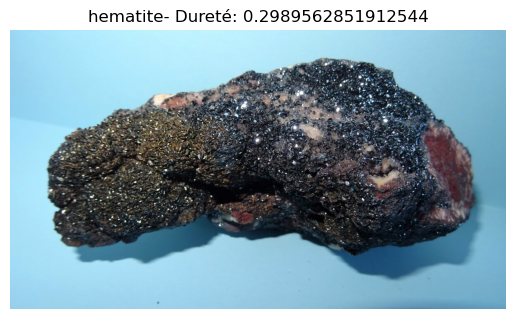

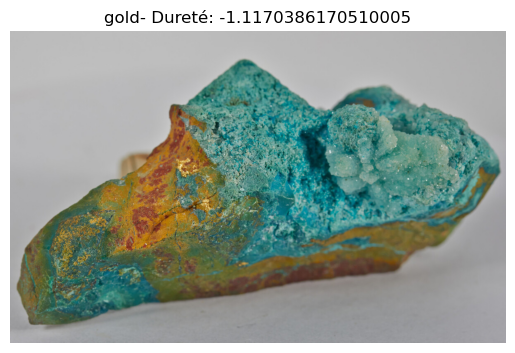

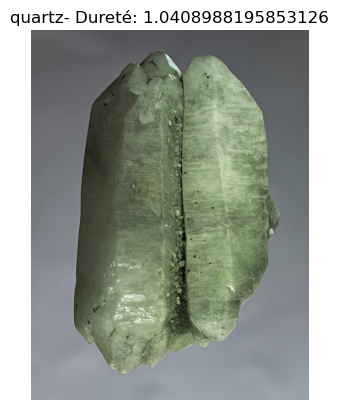

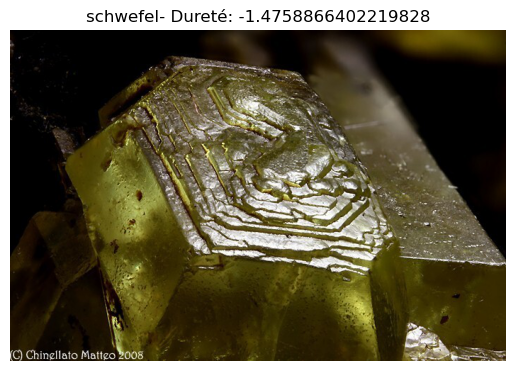

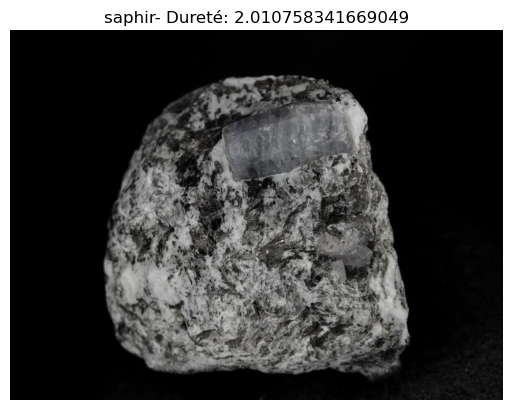

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample = df.sample(5)

for index, row in sample.iterrows():
    img = mpimg.imread(row['image_path'])
    plt.imshow(img)
    plt.title(f"{row['mineral']}- Dureté: {row['durete']}- Densité: {row['densite']}")
    plt.axis('off')
    plt.show()

In [14]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import tensorflow as tf

class MineralDataGen(Sequence):
    def __init__(self, df, batch_size, img_size, image_dir, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_dir = image_dir
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        tabular_data = []
        labels = []

        for _, row in batch.iterrows():
            img_path = os.path.join(self.image_dir, row['image_path'])
            try:
                img = load_img(img_path, target_size=self.img_size)
                img = img_to_array(img) / 255.0

                images.append(img)
                tabular_data.append([row['durete']], [row['densite']])
                labels.append(row['label'])

            except Exception as e:
                print(f"Erreur chargement image {img_path} : {e}")
                continue

        return (np.array(images), np.array(tabular_data)), tf.keras.utils.to_categorical(labels, num_classes=12)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)



In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model

# Entrée image
img_input = Input(shape=(380, 380, 3), name="image_input")
effnet = EfficientNetB4(include_top=False, weights="imagenet", input_tensor=img_input)
effnet.trainable = False
x = GlobalAveragePooling2D()(effnet.output)

# Entrée tabulaire
tab_input = Input(shape=(2,), name="tab_input")
y = Dense(16, activation='relu')(tab_input)

# Fusion des deux
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(32, activation='relu')(z)
output = Dense(len(df['label'].unique()), activation='softmax')(z)

# Modèle
model = Model(inputs=[img_input, tab_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 380, 380, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 380, 380, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 380, 380, 3)       │               7 │ rescaling_4[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_5 (Rescaling)       │ (None, 380, 380, 3)       │               0 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 381, 381, 3)       │               0 │ rescaling_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 190, 190, 48)      │           1,296 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 190, 190, 48)      │             192 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 190, 190, 48)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 190, 190, 48)      │             432 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 190, 190, 48)      │             192 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 190, 190, 48)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 48)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 48)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 12)          │             588 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 48)          │             62

 Total params: 17,792,107 (67.87 MB)

 Trainable params: 118,284 (462.05 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
train_gen = MineralDataGen(train_df, image_dir='images', batch_size=16, img_size=(380, 380))
val_gen = MineralDataGen(val_df, image_dir='images', batch_size=16, img_size=(380, 380))

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks)

C:\Users\dembe\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 4968s 8s/step - accuracy: 0.1364 - loss: 2.4370 - val_accuracy: 0.2515 - val_loss: 2.1613 - learning_rate: 1.0000e-04
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 10019s 17s/step - accuracy: 0.3104 - loss: 2.0268 - val_accuracy: 0.4087 - val_loss: 1.7026 - learning_rate: 1.0000e-04
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 4429s 7s/step - accuracy: 0.4637 - loss: 1.6438 - val_accuracy: 0.5430 - val_loss: 1.4368 - learning_rate: 1.0000e-04
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 5044s 8s/step - accuracy: 0.5519 - loss: 1.4130 - val_accuracy: 0.5809 - val_loss: 1.2692 - learning_rate: 1.0000e-04
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 4494s 7s/step - accuracy: 0.5987 - loss: 1.2458 - val_accuracy: 0.6055 - val_loss: 1.1392 - learning_rate: 1.0000e-04
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 4174s 7s/step - accuracy: 0.6154 - loss: 1.1369 - val_accuracy: 0.7064 - val_loss: 1.0393 - learning_rate: 1.0000e-04
Epoch 7/30
163/600 ━━━━━━━━━━━━━━━━━━━━ 53:22 7s/s

In [8]:
"""#sauvegarde du model
model.save("model_final.h5")

In [3]:
import pickle

# Sauvegarder le label encoder
with open("label_Encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Sauvegarder le scaler
with open("Scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [ ]:
import matplotlib.pyplot as plt

# Courbe d'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()